# Packages

In [1]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns
import astropy.io.fits   as pf   # Pyfits is depracated
import astropy.constants as ct
import ppxf.miles_util   as lib  # MILES library embedded in ppxf
import ppxf.ppxf_util    as util
import ppxf              as ppxf_module
import os
import scipy.interpolate as sci
from ppxf.ppxf           import ppxf
from ppxf.ppxf_util      import log_rebin

# Config. inputs

In [2]:
seds_list    = np.loadtxt('../../../GAMAII_SPEC/WHAN_NA_UVUP/gal_list.txt', dtype=str)
seds_path    = '../../../GAMAII_SPEC/WHAN_NA_UVUP/'
results_path = './Results/'
ppxf_dir     = os.path.dirname(os.path.realpath(ppxf_module.__file__))
miles_lib    = ppxf_dir+'/miles_models/Mun1.30*.fits'
light_speed  = float(str(ct.c.to('km/s')).split(' ')[0])               # selecting the numerical values (must be in km/s)

# Plot parameters (because I'm lazy)

In [3]:
palette      = ['#af8dc3','#f7f7f7','#7fbf7b']
transparency = 0.8
lw           = 2.

# pPXF loop

/home/mlldantas/anaconda3/envs/py3k6/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/home/mlldantas/anaconda3/envs/py3k6/lib/python3.6/site-packages/ppxf/miles_util.py:149: RuntimeWarning: invalid value encountered in sqrt
  FWHM_dif = np.sqrt(FWHM_gal**2 - FWHM_tem**2)


Best Fit:       Vel     sigma        h3        h4
 comp. 0:     22712       181    -0.002    -0.002
chi2/DOF: 0.01439
method = capfit ; Jac calls: 1 ; Func calls: 13 ; Status: 2
Nonzero Templates:  2  /  150
None None [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0. 

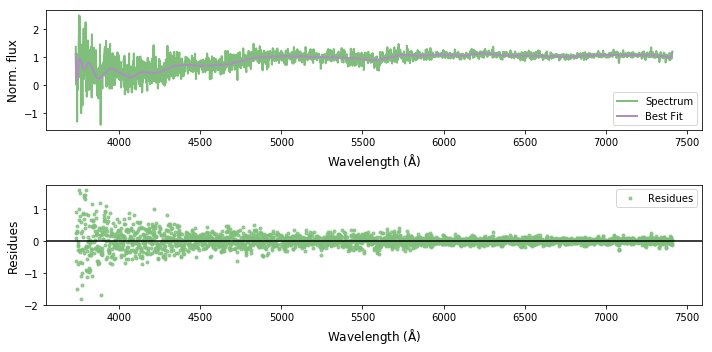

Best Fit:       Vel     sigma        h3        h4
 comp. 0:     56860       180    -0.002    -0.002
chi2/DOF: 0.01724
method = capfit ; Jac calls: 1 ; Func calls: 13 ; Status: 2
Nonzero Templates:  3  /  150
None None [0.00154359 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.07723932 0.
 0.         0.         0.         0.         0.         0.
 0.         0. 

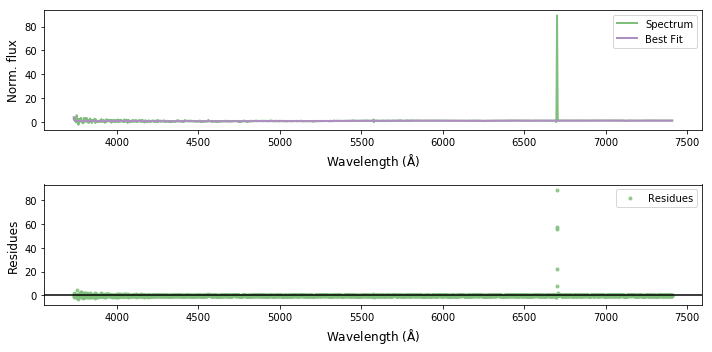

Best Fit:       Vel     sigma        h3        h4
 comp. 0:     71281         1    -0.000    -0.000
chi2/DOF: 0.01264
method = capfit ; Jac calls: 5 ; Func calls: 32 ; Status: 2
Nonzero Templates:  2  /  150
None None [0.00382289 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0. 

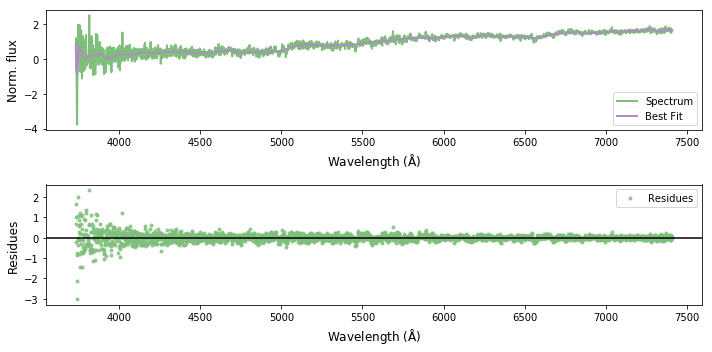

Best Fit:       Vel     sigma        h3        h4
 comp. 0:     58744       181    -0.002    -0.001
chi2/DOF: 0.006124
method = capfit ; Jac calls: 1 ; Func calls: 13 ; Status: 2
Nonzero Templates:  1  /  150
None None [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.

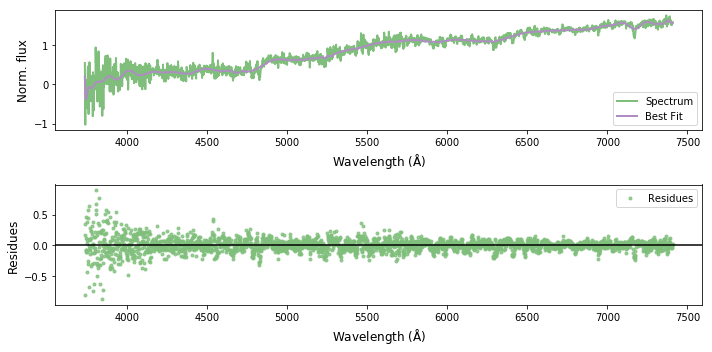

Best Fit:       Vel     sigma        h3        h4
 comp. 0:     59203       182    -0.002    -0.001
chi2/DOF: 0.01015
method = capfit ; Jac calls: 1 ; Func calls: 13 ; Status: 2
Nonzero Templates:  1  /  150
None None [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0. 

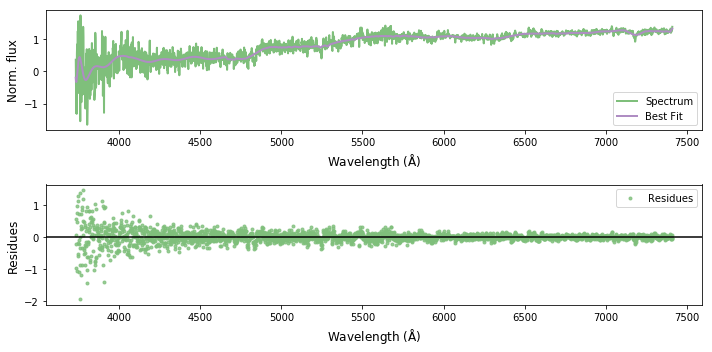

Best Fit:       Vel     sigma        h3        h4
 comp. 0:     47052       241     0.002     0.000
chi2/DOF: 0.009825
method = capfit ; Jac calls: 5 ; Func calls: 31 ; Status: 2
Nonzero Templates:  1  /  150
None None [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.

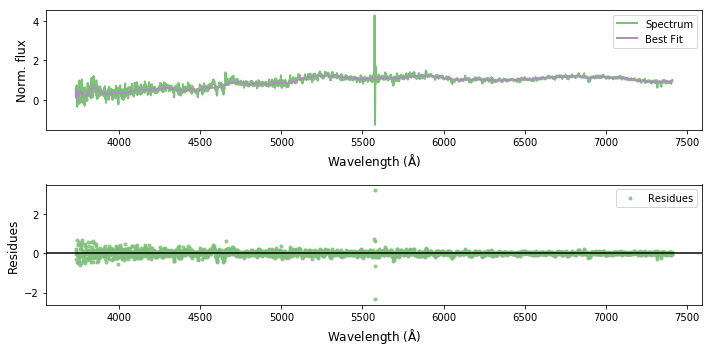

Best Fit:       Vel     sigma        h3        h4
 comp. 0:     70407       400    -0.007    -0.007
chi2/DOF: 0.1054
method = capfit ; Jac calls: 2 ; Func calls: 16 ; Status: 2
Nonzero Templates:  1  /  150
None None [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.00676286
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.     

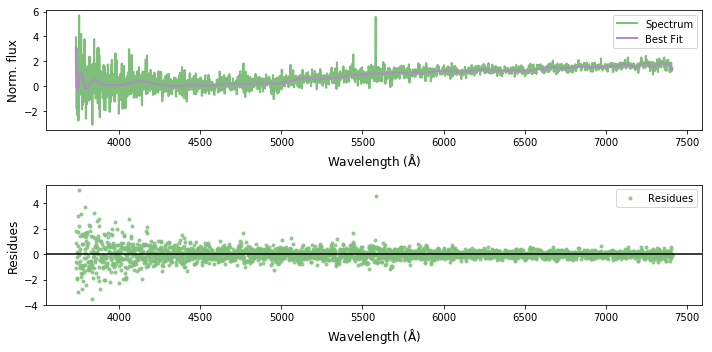

Best Fit:       Vel     sigma        h3        h4
 comp. 0:     31084       271     0.001    -0.000
chi2/DOF: 0.002837
method = capfit ; Jac calls: 8 ; Func calls: 46 ; Status: 2
Nonzero Templates:  1  /  150
None None [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.

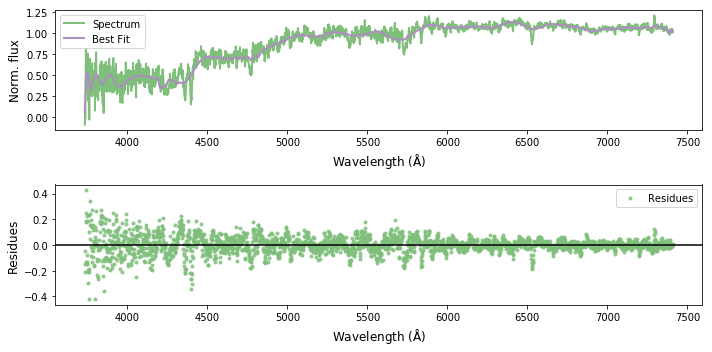

Best Fit:       Vel     sigma        h3        h4
 comp. 0:     52917         5    -0.002    -0.001
chi2/DOF: 0.009851
method = capfit ; Jac calls: 7 ; Func calls: 41 ; Status: 4
Nonzero Templates:  1  /  150
None None [0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.

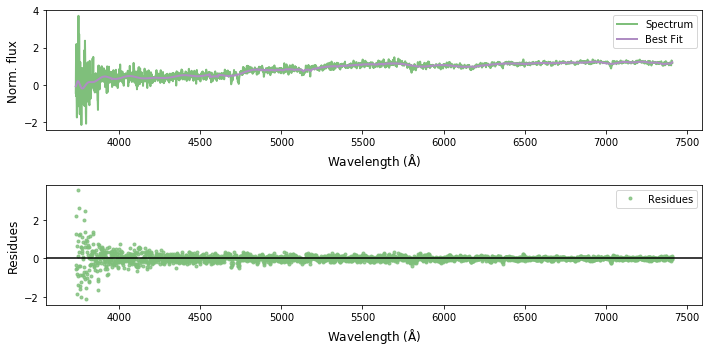

Best Fit:       Vel     sigma        h3        h4
 comp. 0:     61064      1000    -0.002    -0.000
chi2/DOF: 0.007903
method = capfit ; Jac calls: 16 ; Func calls: 90 ; Status: 2
Nonzero Templates:  1  /  150
None None [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0

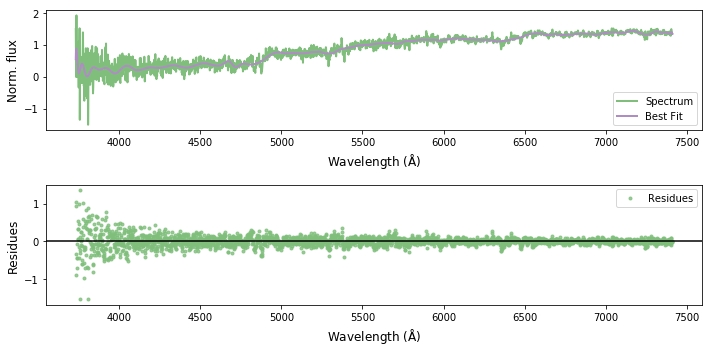

Best Fit:       Vel     sigma        h3        h4
 comp. 0:     47477       118     0.001    -0.001
chi2/DOF: 0.005512
method = capfit ; Jac calls: 7 ; Func calls: 43 ; Status: 2
Nonzero Templates:  1  /  150
None None [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.

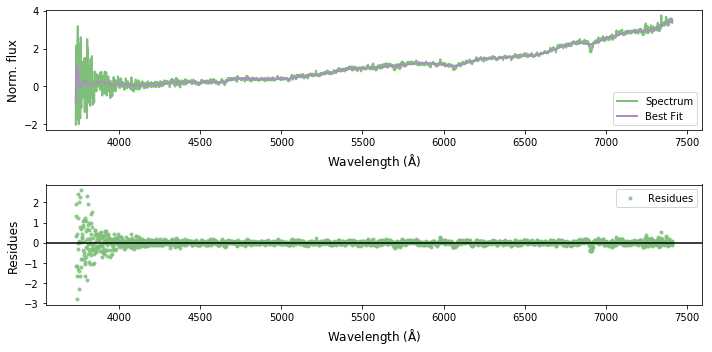

Best Fit:       Vel     sigma        h3        h4
 comp. 0:     70702       812     0.003    -0.002
chi2/DOF: 0.0765
method = capfit ; Jac calls: 3 ; Func calls: 22 ; Status: 2
Nonzero Templates:  2  /  150
None None [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.02134732
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.     

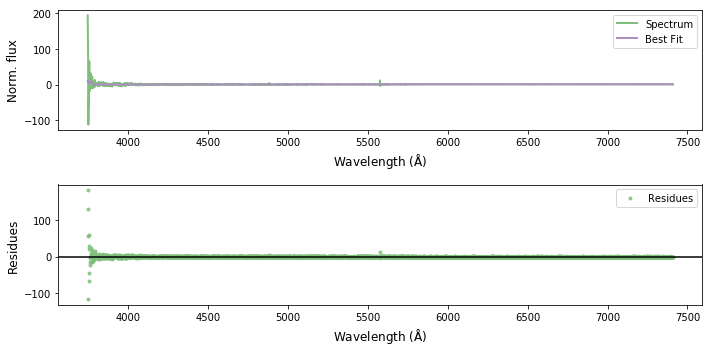

Best Fit:       Vel     sigma        h3        h4
 comp. 0:     61232       916    -0.007     0.021
chi2/DOF: 0.03165
method = capfit ; Jac calls: 9 ; Func calls: 51 ; Status: 2
Nonzero Templates:  2  /  150
None None [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0. 

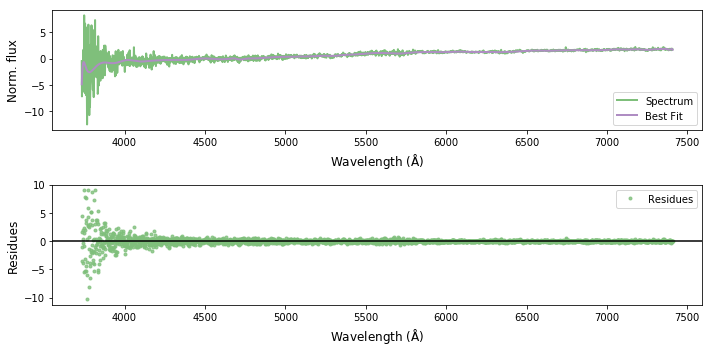

Best Fit:       Vel     sigma        h3        h4
 comp. 0:     46486       333     0.005    -0.005
chi2/DOF: 0.00954
method = capfit ; Jac calls: 6 ; Func calls: 36 ; Status: 2
Nonzero Templates:  2  /  150
None None [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0. 

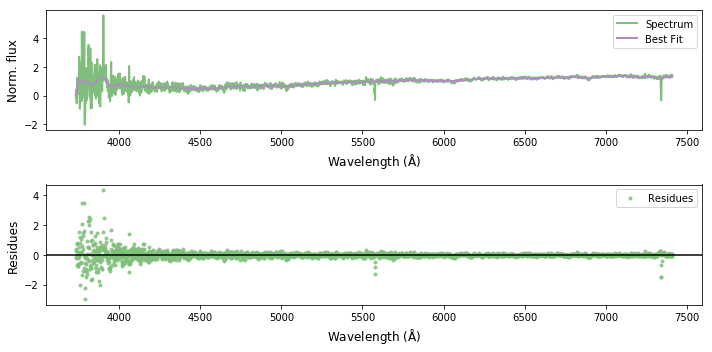

Best Fit:       Vel     sigma        h3        h4
 comp. 0:     54033       258     0.001    -0.000
chi2/DOF: 0.005202
method = capfit ; Jac calls: 13 ; Func calls: 72 ; Status: 2
Nonzero Templates:  1  /  150
None None [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0

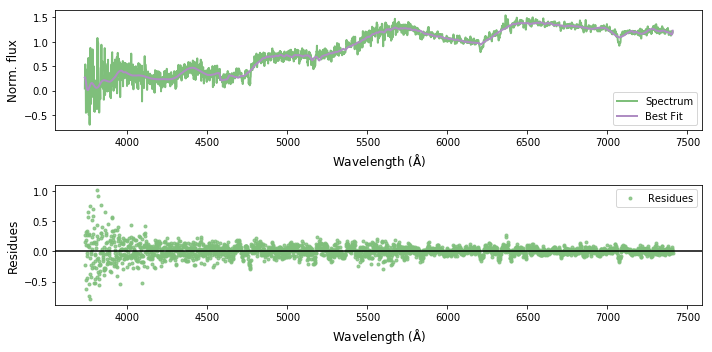

Best Fit:       Vel     sigma        h3        h4
 comp. 0:     44394      1000    -0.089     0.039
chi2/DOF: 0.004172
method = capfit ; Jac calls: 28 ; Func calls: 149 ; Status: 2
Nonzero Templates:  1  /  150
None None [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         

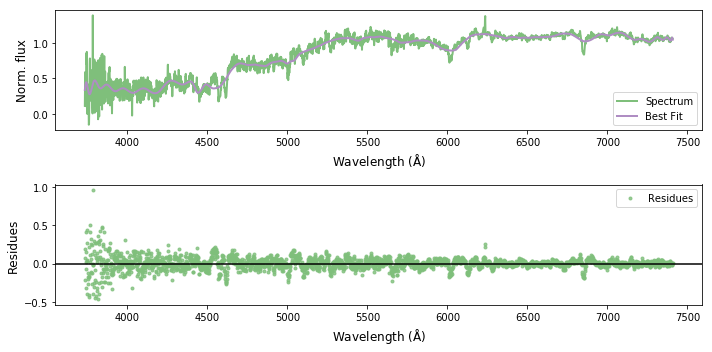

Best Fit:       Vel     sigma        h3        h4
 comp. 0:     38717        36    -0.002     0.001
chi2/DOF: 0.007824
method = capfit ; Jac calls: 11 ; Func calls: 61 ; Status: 2
Nonzero Templates:  2  /  150
None None [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0

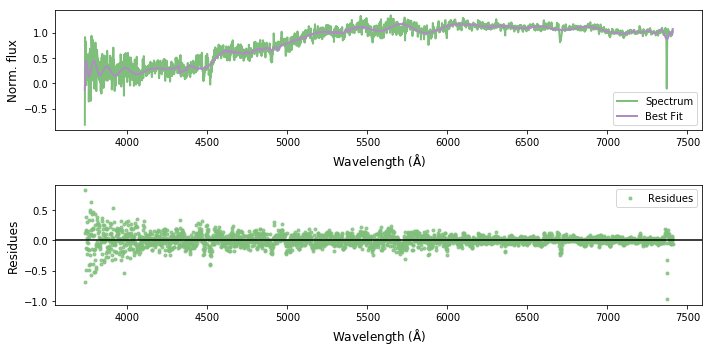

Best Fit:       Vel     sigma        h3        h4
 comp. 0:     69470       238    -0.001     0.003
chi2/DOF: 0.007297
method = capfit ; Jac calls: 20 ; Func calls: 111 ; Status: 2
Nonzero Templates:  2  /  150
None None [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.00557525 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         

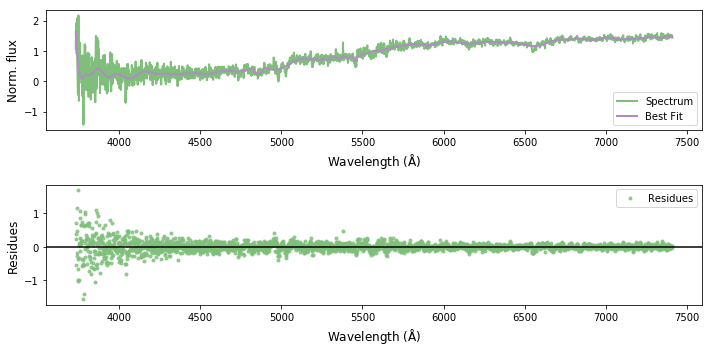

Best Fit:       Vel     sigma        h3        h4
 comp. 0:     63686      1000    -0.007     0.010
chi2/DOF: 0.01371
method = capfit ; Jac calls: 23 ; Func calls: 124 ; Status: 2
Nonzero Templates:  1  /  150
None None [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0

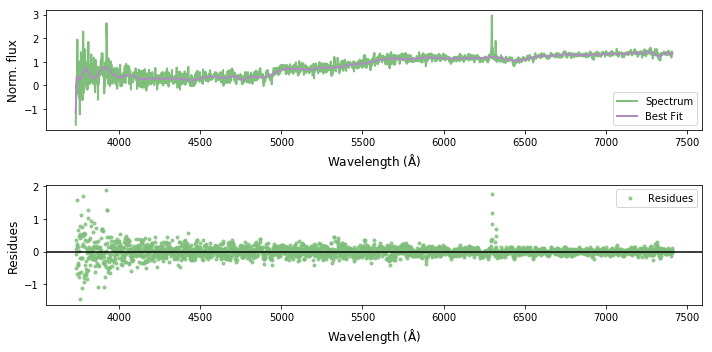

Best Fit:       Vel     sigma        h3        h4
 comp. 0:     66903      1000     0.300    -0.099
chi2/DOF: 0.02237
method = capfit ; Jac calls: 13 ; Func calls: 71 ; Status: 2
Nonzero Templates:  2  /  150
None None [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.01499831  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 

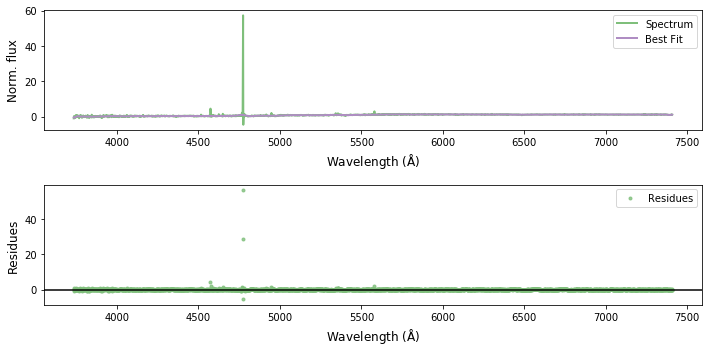

Best Fit:       Vel     sigma        h3        h4
 comp. 0:     49848       271     0.001    -0.001
chi2/DOF: 0.01206
method = capfit ; Jac calls: 6 ; Func calls: 36 ; Status: 2
Nonzero Templates:  1  /  150
None None [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0. 

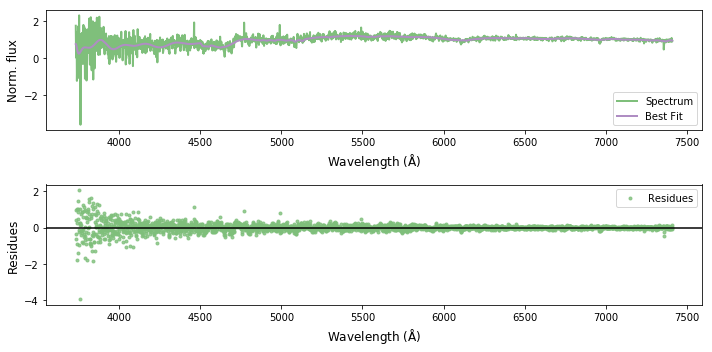

Best Fit:       Vel     sigma        h3        h4
 comp. 0:     70251      1000    -0.000    -0.000
chi2/DOF: 0.01309
method = capfit ; Jac calls: 15 ; Func calls: 82 ; Status: 2
Nonzero Templates:  2  /  150
None None [0.00624951 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.

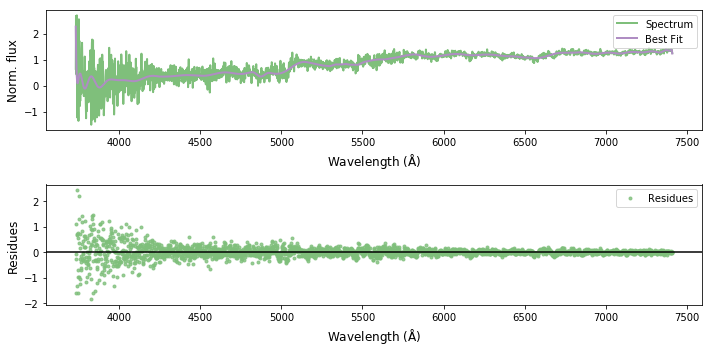

Best Fit:       Vel     sigma        h3        h4
 comp. 0:     68945         1    -0.004    -0.004
chi2/DOF: 0.008668
method = capfit ; Jac calls: 1 ; Func calls: 12 ; Status: 2
Nonzero Templates:  0  /  150
None None [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.] 2


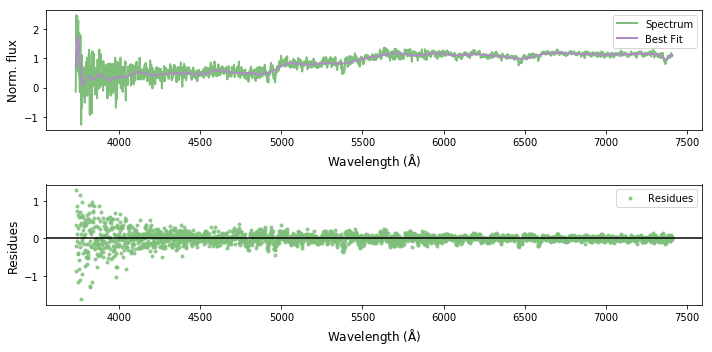

Best Fit:       Vel     sigma        h3        h4
 comp. 0:     67051      1000     0.077     0.063
chi2/DOF: 0.01427
method = capfit ; Jac calls: 15 ; Func calls: 83 ; Status: 2
Nonzero Templates:  2  /  150
None None [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.

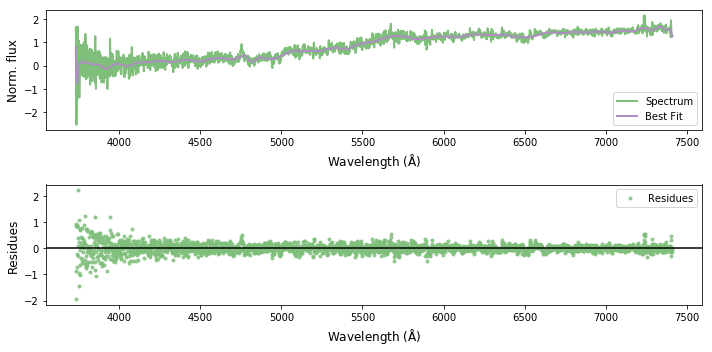

Best Fit:       Vel     sigma        h3        h4
 comp. 0:     53250      1000    -0.158    -0.025
chi2/DOF: 0.005012
method = capfit ; Jac calls: 18 ; Func calls: 97 ; Status: 2
Nonzero Templates:  2  /  150
None None [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.20172079
 0.  

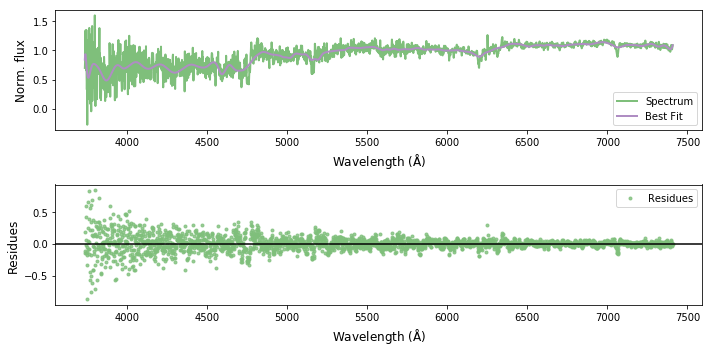

Best Fit:       Vel     sigma        h3        h4
 comp. 0:     48598       252    -0.001    -0.001
chi2/DOF: 0.02902
method = capfit ; Jac calls: 4 ; Func calls: 27 ; Status: 2
Nonzero Templates:  1  /  150
None None [0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.      

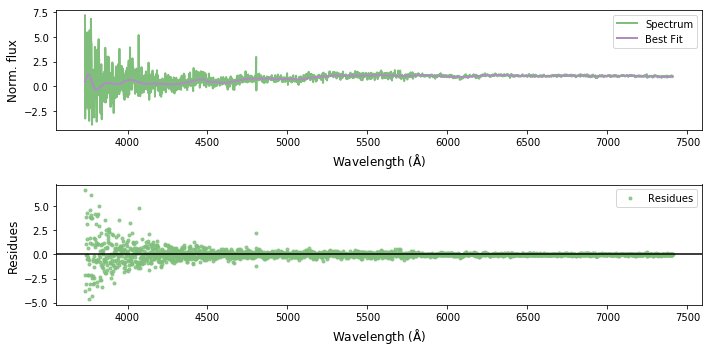

Best Fit:       Vel     sigma        h3        h4
 comp. 0:     68048       137     0.001    -0.001
chi2/DOF: 0.01519
method = capfit ; Jac calls: 4 ; Func calls: 27 ; Status: 2
Nonzero Templates:  2  /  150
None None [0.00519997 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0. 

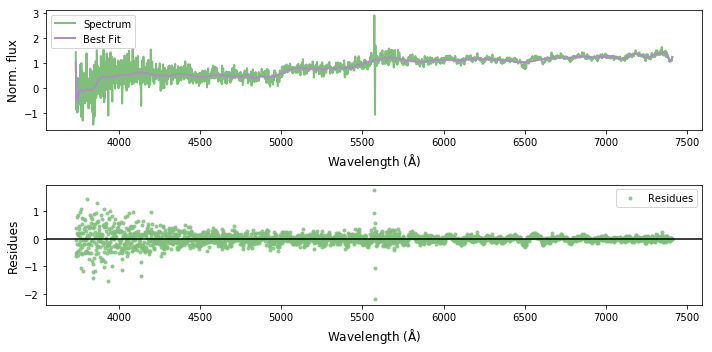

Best Fit:       Vel     sigma        h3        h4
 comp. 0:     52942        82    -0.001    -0.002
chi2/DOF: 0.01573
method = capfit ; Jac calls: 10 ; Func calls: 56 ; Status: 4
Nonzero Templates:  1  /  150
None None [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.

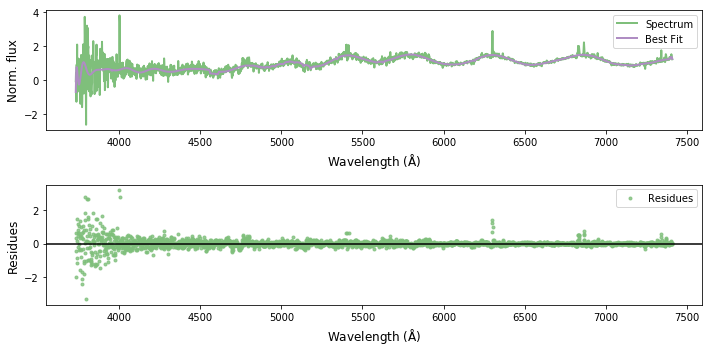

In [4]:
for each_sed in range(seds_list.size):
    # flux ----------------------------------------------------------------------------------------------------------------
    sed_file  = os.path.join(seds_path, seds_list[each_sed])          # link between path and files
    sed_flux  = pf.getdata(sed_file)[0]                               # opening each spectra
    sed_err   = pf.getdata(sed_file)[1]                               # opening each spectra error
    
    # wavelength ----------------------------------------------------------------------------------------------------------
    sed_header = pf.open(sed_file)[0].header
    sed_wl_ini = sed_header['WMIN'] 
    sed_wl_stp = sed_header['CD1_1']
    sed_wl     = np.arange(sed_flux.size)*(sed_wl_stp)+sed_wl_ini
    
    # cleaning flux and wavelength trash ----------------------------------------------------------------------------------
    idx_clean       = np.where((np.logical_not(np.isnan(sed_flux)))*(sed_err>0))    # indices where NAN is present
    flux_temp       = sed_flux[idx_clean]                                         # removing NAN values from spectra
    flux_temp_err   = sed_err[idx_clean]
    wavelength_temp = sed_wl[idx_clean]
    
    # limiting the spectrum regarding the wavelength range of the library -------------------------------------------------
    wl_lib_idx = (wavelength_temp>3540) & (wavelength_temp<7409)       # MILES wavelength range
    flux       = flux_temp[wl_lib_idx]
    flux_err   = flux_temp_err[wl_lib_idx]
    wavelength = wavelength_temp[wl_lib_idx]
    
    # other important parameters ------------------------------------------------------------------------------------------
    redshift = sed_header['Z']
    cataid   = sed_header['CATAID']
    
    # ppxf ----------------------------------------------------------------------------------------------------------------
    ### parameters --------------------------------------------------------------------------------------------------------
    vel_scale          = light_speed*np.log(wavelength[1]/wavelength[0])            # velocity scale - Eq.8 Capellari 2017
    fwhm_gama          = 2.                                       # MUST BE CHECKED!!!!! This is just a temporary value!!!
    miles              = lib.miles(miles_lib, vel_scale, fwhm_gama)
    stellar_templates  = miles.templates.reshape(miles.templates.shape[0], -1)
    dv                 = light_speed*(miles.log_lam_temp[0] - np.log(wavelength[0]))  # eq.(8) of Cappellari (2017)
    vel                = light_speed*np.log(1 + redshift)                             # eq.(8) of Cappellari (2017)
    start              = [vel, 180.]        
    
    ### rebinning the spectrum so it is at the same size as the templates (or smaller) ------------------------------------
    new_shape          = stellar_templates[:,0].shape
    rebinning_function = sci.interp1d(wavelength, flux)   # for the flux
    wavelength_rebin   = np.linspace(start=wavelength.min(), stop=wavelength.max(), num=int(new_shape[0]))
    flux_rebin         = rebinning_function(wavelength_rebin)
    
    ### rebinning the error -----------------------------------------------------------------------------------------------
    rebin_func_error   = sci.interp1d(wavelength, flux_err)
    wl_rebin_error     = np.linspace(start=wavelength.min(), stop=wavelength.max(), num=int(new_shape[0]))
    flux_err_rebin     = rebin_func_error(wl_rebin_error)
    
    ### final galaxy spectrum and its error to be analysed ----------------------------------------------------------------
    galaxy             = flux_rebin/np.median(flux_rebin)                  # Normalize spectrum to avoid numerical issues
    noise              = flux_err_rebin/np.median(flux_err_rebin)          # idem
 
    
    ### SED FITTING WITH PPXF ---------------------------------------------------------------------------------------------
    sed_fit = ppxf(templates=stellar_templates, galaxy=galaxy, noise=noise, velscale=vel_scale, start=start, plot=False, 
                   lam=wavelength_rebin, moments=4, degree=50)
    
    residues = (galaxy-sed_fit.bestfit)
    
    print (sed_fit.gas_mpoly, sed_fit.gas_reddening, sed_fit.weights, sed_fit.status)
    
    ### Saving plots ------------------------------------------------------------------------------------------------------
    plt.subplots(figsize=(10,5))
    plt.subplot(2,1,1)
    plt.plot(wavelength_rebin, sed_fit.galaxy, '-', color=palette[-1], linewidth=lw, label="Spectrum")
    plt.plot(wavelength_rebin, sed_fit.bestfit, '-', color=palette[0], linewidth=lw, label="Best Fit")
    plt.legend(loc='best')
    plt.xlabel("Wavelength ($\mathrm{\AA}$)", fontsize=12)
    plt.ylabel("Norm. flux", fontsize=12)
    plt.subplot(2,1,2)
    plt.plot(wavelength_rebin, residues, '.', color=palette[-1], linewidth=lw, label="Residues", alpha=transparency)
    plt.axhline(y=0, c='black')
    plt.legend(loc='best')
    plt.xlabel("Wavelength ($\mathrm{\AA}$)", fontsize=12)
    plt.ylabel("Residues", fontsize=12)
    plt.tight_layout()
    plt.savefig(os.path.join('./../../Codes/SEDFitting/Results/', 'gal_'+str(cataid)+'.png'))
    plt.show()